Seek his will in all you do, and he will show you which path to take.
Proverbs 3:6

Use QAOA to verify the partitioning of neurons by cortical depth.


## Data Loading

In [5]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats, signal
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from scipy.stats import binomtest, binned_statistic 
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score  
from sklearn.metrics import silhouette_score
import networkx as nx
from tqdm import tqdm
import pickle

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Import custom modules
from pathlib import Path
import sys
PROJECT_ROOT = Path().resolve().parent  
sys.path.insert(0, str(PROJECT_ROOT))

from src.dataio.config import DATA_DIR, FILESYSTEM_CONFIG
from src.dataio.data_structures import SessionData
from src.dataio.loaders import load_session_complete
from src.dataio.processors import ResponseProcessor, NetworkAnalyzer, DimensionalityReducer
from src.dataio.validators import validate_session_comprehensive, analyze_session_quality
from src import features

In [6]:
DATA_DIR = Path('../data/raw')

# Find all subdirs that contain the expected .mat file
MAT_FILENAME = 'allPlanesVariables27-Feb-2021.mat'
sessions = sorted([
    d.name
    for d in DATA_DIR.iterdir()
    if d.is_dir() and (d / MAT_FILENAME).is_file()
])

print(f"Discovered {len(sessions)} sessions:")
for s in sessions:
    print("  ", s)

# Choose your primary session here (must be one of the discovered names)
PRIMARY_SESSION = '081820_355n'
if PRIMARY_SESSION not in sessions:
    raise ValueError(f"Primary session '{PRIMARY_SESSION}' not found in data/. Available: {sessions}")

print(f"\nPrimary analysis session: {PRIMARY_SESSION}")

# --- now load & process as before ---

session_path = DATA_DIR / PRIMARY_SESSION
print(f"Loading session from: {session_path}")

session = load_session_complete(session_path, use_cache=True)

validation_result = validate_session_comprehensive(session)
quality_report     = analyze_session_quality(session)

print(f"\nSession loaded successfully!")
print(f"Neurons: {len(session.neurons)}")
print(f"Trials:  {len(session.trials)}")
print(f"Activity matrix shape: {session.activity_matrix.shape}")
print(f"Data quality score: {quality_report['overall_score']:.2f}")


Discovered 9 sessions:
   031020_367n_100um20st_FRA
   031020_367r_100um20st_FRA
   031120_352ll_100um20st_FRA
   031120_352ll_100um20st_FRA_diffxy
   080720_400r
   081820_355n
   081920_355l
   081920_355r
   082620_355l

Primary analysis session: 081820_355n
Loading session from: ../data/raw/081820_355n


VALIDATION WARNING: Unexpected trial count: 22. Expected one of [90, 180]
VALIDATION WARNING: Activity matrix contains 4 NaN values (0.00%).



Session loaded successfully!
Neurons: 416
Trials:  22
Activity matrix shape: (416, 2060)
Data quality score: 1.00


## Natural Assembly

--- Part 1: Discovering Natural Assemblies ---
Computing correlation matrix from activity data...
Determining optimal number of clusters using silhouette score...
Found optimal number of clusters: 50


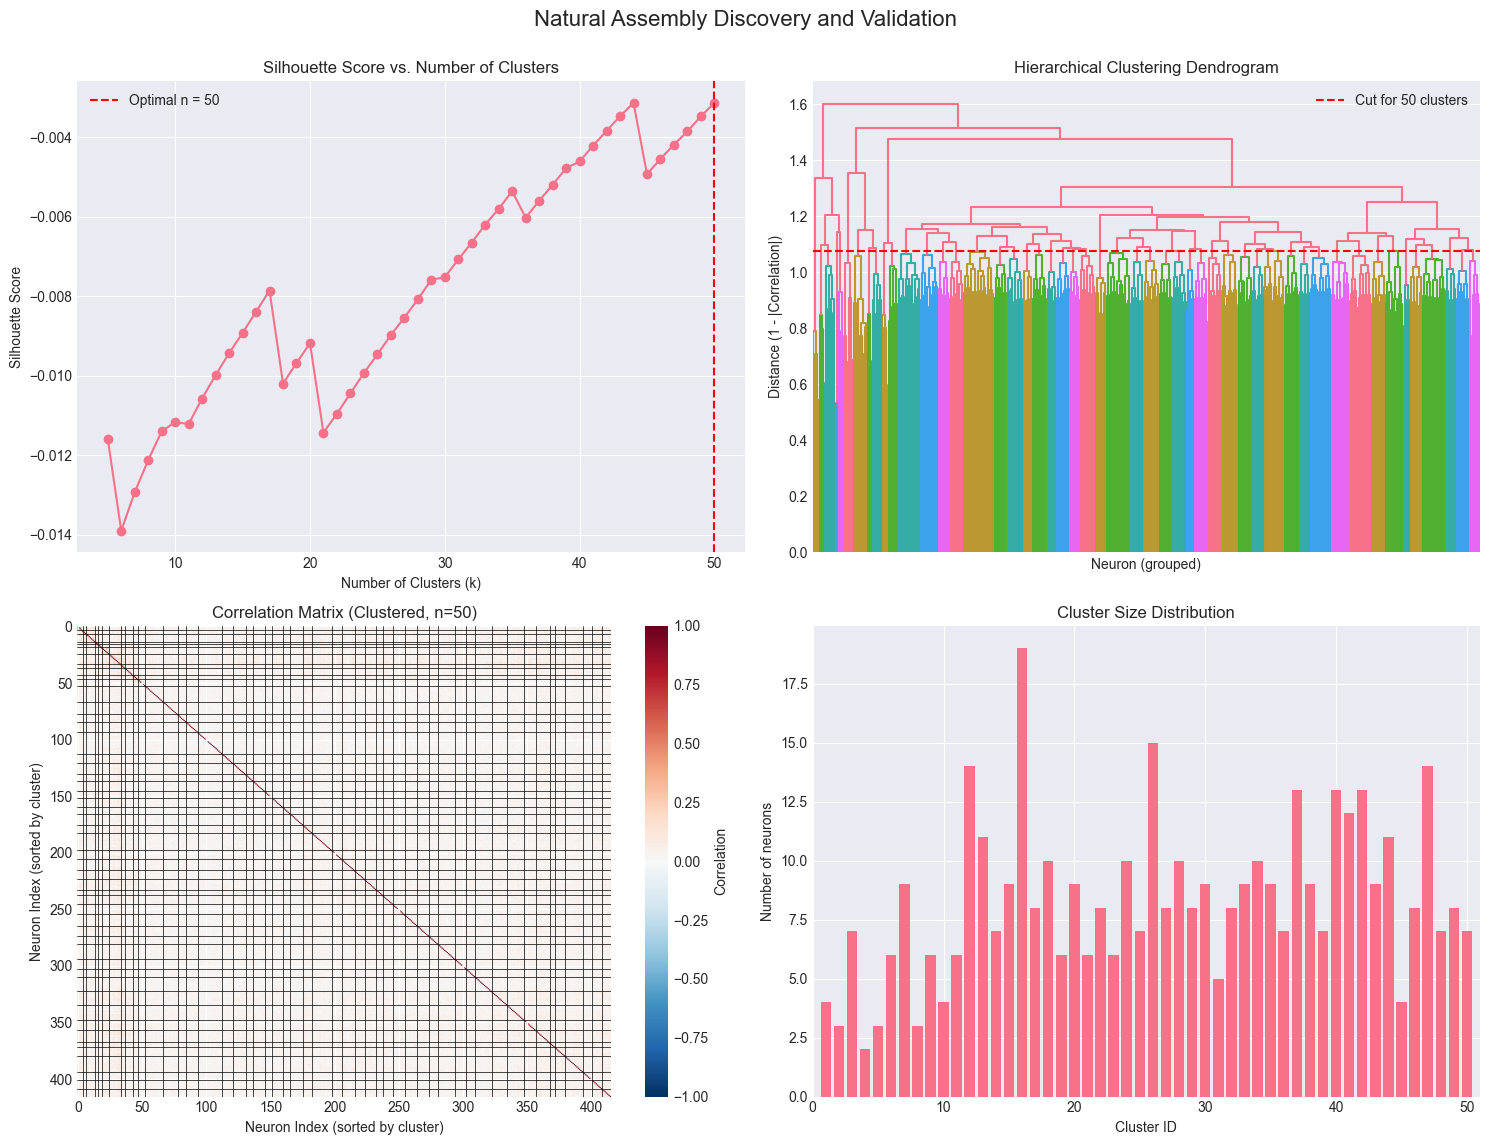

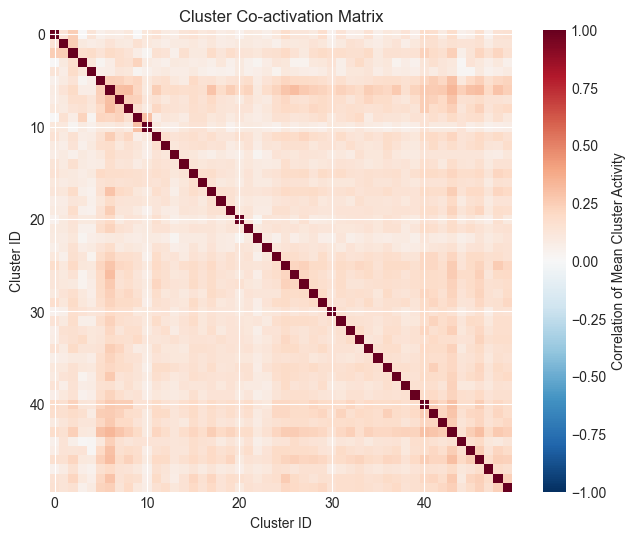


--- Natural Assembly Statistics ---
Number of natural clusters found: 50
Cluster sizes: Min=2, Max=19, Mean=8.3 ± 3.4

--- Part 2: Spatial and Functional Analysis ---
Analyzing spatial coherence with permutation testing...
Analyzing functional (Best Frequency) coherence...


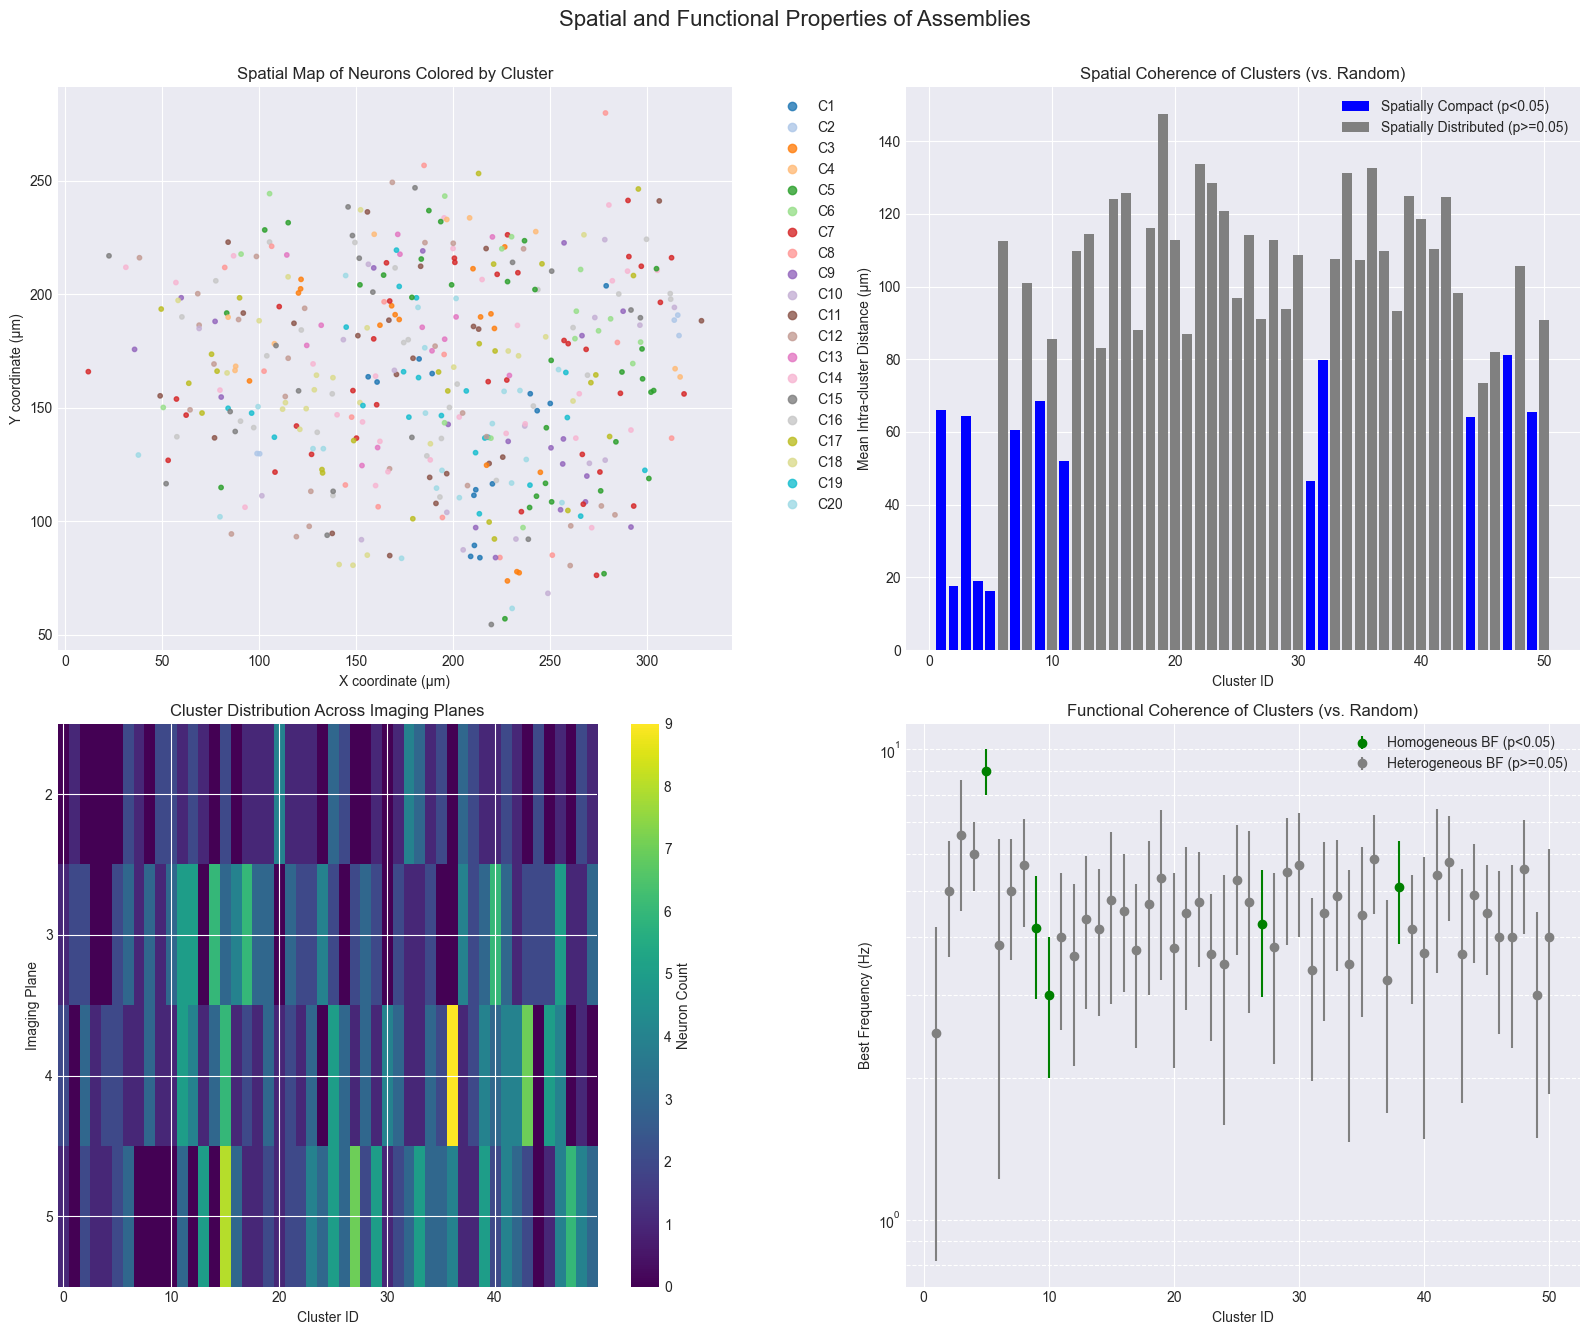


--- Spatial and Functional Summary ---
13 out of 50 clusters are significantly compact.
5 out of 50 clusters have significantly homogeneous BFs.

--- Part 3: Stimulus Specificity Analysis ---
Found trial data. Analyzing cluster responses...


AttributeError: module 'src.features' has no attribute 'calculate_stimulus_response_matrix'

In [7]:
# ===================================================================
# Part 1: Natural Assembly Discovery
# ===================================================================
# We begin by identifying neuronal assemblies without making assumptions about
# their number. We use hierarchical clustering based on activity correlations.
# The key step is to find the optimal number of clusters.

print("--- Part 1: Discovering Natural Assemblies ---")

# --- 1.1: Calculate Correlation and Linkage Matrices ---
# Use the new, clean functions from src/features.py
if hasattr(session, 'signal_correlations') and session.signal_correlations is not None:
    print("Using pre-computed signal correlations.")
    corr_matrix = session.signal_correlations
else:
    print("Computing correlation matrix from activity data...")
    corr_matrix = features.pearson_corr_matrix(session.activity_matrix)

full_corr = corr_matrix.copy() # Keep a copy for later use
linkage_matrix = features.calculate_linkage_matrix(corr_matrix, method='ward')

# --- 1.2: Determine Optimal Number of Clusters ---
print("Determining optimal number of clusters using silhouette score...")
n_clusters_range = range(5, 51)
optimal_n_clusters, silhouette_scores = features.find_optimal_clusters_silhouette(
    linkage_matrix, corr_matrix, n_clusters_range
)
cluster_labels = features.get_cluster_labels(linkage_matrix, optimal_n_clusters)
unique_clusters = np.unique(cluster_labels)

print(f"Found optimal number of clusters: {optimal_n_clusters}")

# --- 1.3: Visualization and Statistics ---
# Visualization logic remains in the notebook.
plt.figure(figsize=(15, 12))

# Plot Silhouette Score to justify our choice
plt.subplot(2, 2, 1)
plt.plot(n_clusters_range, silhouette_scores, 'o-')
plt.axvline(optimal_n_clusters, color='r', linestyle='--', label=f'Optimal n = {optimal_n_clusters}')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)

# Plot Dendrogram with the determined cluster threshold
plt.subplot(2, 2, 2)
cut_distance = linkage_matrix[-(optimal_n_clusters - 1), 2]
hierarchy.dendrogram(linkage_matrix, no_labels=True, color_threshold=cut_distance)
plt.axhline(cut_distance, color='r', linestyle='--', label=f'Cut for {optimal_n_clusters} clusters')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neuron (grouped)')
plt.ylabel('Distance (1 - |Correlation|)')
plt.legend()

# Reorder correlation matrix by the found clusters
cluster_order = np.argsort(cluster_labels)
corr_matrix_clustered = corr_matrix[cluster_order][:, cluster_order]

plt.subplot(2, 2, 3)
plt.imshow(corr_matrix_clustered, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlation')
plt.title(f'Correlation Matrix (Clustered, n={optimal_n_clusters})')
plt.xlabel('Neuron Index (sorted by cluster)')
plt.ylabel('Neuron Index (sorted by cluster)')
cluster_boundaries = np.where(np.diff(cluster_labels[cluster_order]))[0] + 0.5
for boundary in cluster_boundaries:
    plt.axhline(boundary, color='black', lw=0.5)
    plt.axvline(boundary, color='black', lw=0.5)

# Cluster size distribution
plt.subplot(2, 2, 4)
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster ID')
plt.ylabel('Number of neurons')
plt.title('Cluster Size Distribution')
plt.xlim([0, optimal_n_clusters + 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Natural Assembly Discovery and Validation', fontsize=16)
plt.show()

# --- 1.4: Cluster Co-activation ---
cluster_activity_matrix, cluster_corr = features.calculate_cluster_coactivation(
    session.activity_matrix, cluster_labels
)

plt.figure(figsize=(8, 6))
plt.imshow(cluster_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation of Mean Cluster Activity')
plt.title('Cluster Co-activation Matrix')
plt.xlabel('Cluster ID')
plt.ylabel('Cluster ID')
plt.show()

print("\n--- Natural Assembly Statistics ---")
print(f"Number of natural clusters found: {optimal_n_clusters}")
print(f"Cluster sizes: Min={cluster_sizes.min()}, Max={cluster_sizes.max()}, Mean={cluster_sizes.mean():.1f} ± {cluster_sizes.std():.1f}")


# ===================================================================
# Part 2: Spatial and Functional Analysis of Assemblies
# ===================================================================
print("\n--- Part 2: Spatial and Functional Analysis ---")
# Data preparation for this section
neuron_coords = np.array([[n.x, n.y, n.z] for n in session.neurons])
neuron_planes = np.array([n.plane for n in session.neurons])
bf_values = np.array([getattr(n, 'best_frequency', np.nan) for n in session.neurons], dtype=float)

# --- 2.1: Spatial Coherence Analysis ---
print("Analyzing spatial coherence with permutation testing...")
cluster_spatial_stats = features.analyze_spatial_coherence(
    neuron_coords, cluster_labels, n_permutations=1000
)

# --- 2.2: Functional (Best Frequency) Coherence Analysis ---
print("Analyzing functional (Best Frequency) coherence...")
cluster_bf_stats = features.analyze_functional_coherence(
    bf_values, cluster_labels, n_permutations=1000
)

# --- 2.3: Visualization of Spatial and Functional Properties ---
fig, axes = plt.subplots(2, 2, figsize=(16, 14), gridspec_kw={'height_ratios': [1, 1]})
# a) Spatial distribution in XY plane
ax = axes[0, 0]
scatter = ax.scatter(neuron_coords[:, 0], neuron_coords[:, 1], s=10, c=cluster_labels, cmap='tab20', alpha=0.8)
ax.set_xlabel('X coordinate (µm)'); ax.set_ylabel('Y coordinate (µm)')
ax.set_title('Spatial Map of Neurons Colored by Cluster')
ax.legend(handles=scatter.legend_elements(num=min(20, optimal_n_clusters))[0],
          labels=[f'C{i}' for i in range(1, min(20, optimal_n_clusters) + 1)],
          bbox_to_anchor=(1.05, 1), loc='upper left')
# b) Spatial Coherence Results
ax = axes[0, 1]
compact_clusters = {k: v for k, v in cluster_spatial_stats.items() if v.get('is_compact')}
distrib_clusters = {k: v for k, v in cluster_spatial_stats.items() if not v.get('is_compact')}
if compact_clusters:
    ax.bar(compact_clusters.keys(), [v['mean_dist'] for v in compact_clusters.values()], color='blue', label='Spatially Compact (p<0.05)')
if distrib_clusters:
    ax.bar(distrib_clusters.keys(), [v['mean_dist'] for v in distrib_clusters.values()], color='gray', label='Spatially Distributed (p>=0.05)')
ax.set_xlabel('Cluster ID'); ax.set_ylabel('Mean Intra-cluster Distance (µm)')
ax.set_title('Spatial Coherence of Clusters (vs. Random)'); ax.legend()
# c) Distribution across planes
ax = axes[1, 0]
plane_cluster_matrix = pd.crosstab(neuron_planes, cluster_labels)
im = ax.imshow(plane_cluster_matrix, aspect='auto', cmap='viridis', interpolation='none')
ax.set_xlabel('Cluster ID'); ax.set_ylabel('Imaging Plane')
ax.set_yticks(ticks=range(len(plane_cluster_matrix.index)), labels=plane_cluster_matrix.index)
ax.set_title('Cluster Distribution Across Imaging Planes'); plt.colorbar(im, ax=ax, label='Neuron Count')
# d) Functional (BF) Coherence Results
ax = axes[1, 1]
homog_clusters = {k: v for k, v in cluster_bf_stats.items() if v.get('is_homog')}
hetero_clusters = {k: v for k, v in cluster_bf_stats.items() if not v.get('is_homog')}
if homog_clusters:
    ax.errorbar(homog_clusters.keys(), [v['mean_bf'] for v in homog_clusters.values()], yerr=[10**v['std_log_bf'] for v in homog_clusters.values()], fmt='o', color='green', label='Homogeneous BF (p<0.05)')
if hetero_clusters:
    ax.errorbar(hetero_clusters.keys(), [v['mean_bf'] for v in hetero_clusters.values()], yerr=[10**v['std_log_bf'] for v in hetero_clusters.values()], fmt='o', color='gray', label='Heterogeneous BF (p>=0.05)')
ax.set_yscale('log'); ax.set_xlabel('Cluster ID'); ax.set_ylabel('Best Frequency (Hz)')
ax.set_title('Functional Coherence of Clusters (vs. Random)'); ax.legend()
ax.grid(True, which="both", ls="--", axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Spatial and Functional Properties of Assemblies', fontsize=16)
plt.show()

# --- Summary Printout ---
print("\n--- Spatial and Functional Summary ---")
if cluster_spatial_stats:
    n_compact = sum(v.get('is_compact', False) for v in cluster_spatial_stats.values())
    print(f"{n_compact} out of {len(cluster_spatial_stats)} clusters are significantly compact.")
if cluster_bf_stats:
    n_homog = sum(v.get('is_homog', False) for v in cluster_bf_stats.values())
    print(f"{n_homog} out of {len(cluster_bf_stats)} clusters have significantly homogeneous BFs.")


# ===================================================================
# Part 3: Stimulus-Specificity of Assemblies
# ===================================================================
print("\n--- Part 3: Stimulus Specificity Analysis ---")
if session.trials:
    print("Found trial data. Analyzing cluster responses...")
    
    # Prepare stimulus table from session data
    stim_table = pd.DataFrame([t.to_dict() for t in session.trials])
    stim_table.rename(columns={'condition': 'stimulus_name'}, inplace=True)
    
    # Calculate cluster response matrix using the new feature function
    cluster_response_matrix = features.calculate_stimulus_response_matrix(
        cluster_activity_matrix, unique_clusters, stim_table, session.activity_matrix.shape
    )

    # Normalize responses for visualization (z-score across stimuli for each cluster)
    cluster_response_zscored = cluster_response_matrix.apply(
        lambda x: zscore(x, nan_policy='omit') if x.std(ddof=0) > 0 else x,
        axis=1, result_type='expand'
    )
    cluster_response_zscored.columns = cluster_response_matrix.columns
    
    # --- Visualization ---
    plt.figure(figsize=(12, 10))
    im = plt.imshow(cluster_response_zscored.fillna(0), cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Z-scored Mean Activity during Stimulus')
    plt.title('Cluster Selectivity to Stimuli')
    plt.xlabel('Stimulus Name'); plt.ylabel('Cluster ID')
    plt.xticks(ticks=range(len(cluster_response_matrix.columns)), labels=cluster_response_matrix.columns, rotation=90)
    plt.yticks(ticks=range(len(cluster_response_matrix.index)), labels=cluster_response_matrix.index)
    plt.show()
    
    # --- Identify Core vs. Specific Clusters ---
    max_zscores = cluster_response_zscored.max(axis=1)
    specific_clusters = max_zscores[max_zscores > 2.0].index.tolist()
    core_clusters = max_zscores.index.difference(specific_clusters).tolist()

    print("\n--- Stimulus Specificity Summary ---")
    print(f"Found {len(specific_clusters)} potentially stimulus-specific clusters (max response > 2 Z).")
    print(f"IDs: {specific_clusters}")
    print(f"\nFound {len(core_clusters)} potential core/non-selective clusters.")
    print(f"IDs: {core_clusters}")
else:
    print("Skipping stimulus-specificity analysis: 'session.trials' not found or is empty.")